# CIFAR 10 Convolutional Neural Network

# Check for CUDA

In [6]:
import torch
import numpy as np

# check for CUDA
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


# Grab Data

In [11]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# subprocesses for dataloading
num_workers = 0

# samples per batch
batch_size = 20

# Validation set size in percent
valid_size = 0.2

# normalize data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load data
train_data = datasets.CIFAR10("data", train=True, download=True, transform=transform)
test_data = datasets.CIFAR10("data", train=False, download=True, transform=transform)

# split data
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx, valid_idx = indices[split:], indices[:split]

#define samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


# Visualize

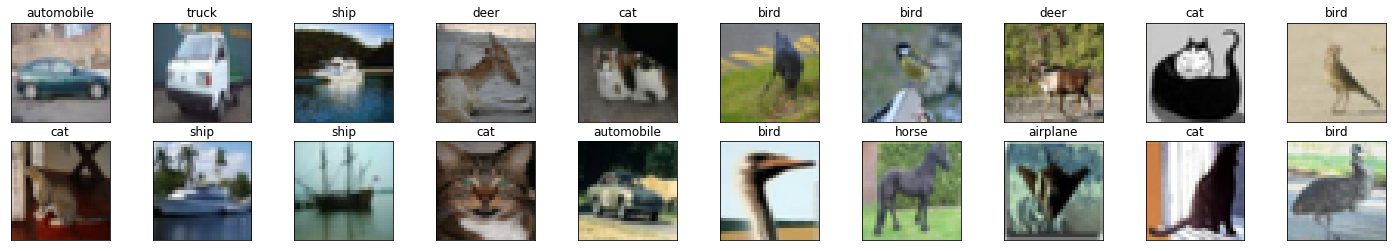

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain a batch
images, labels = iter(train_loader).next()
images = images.numpy()

#plot
fig = plt.figure(figsize=(25,4))
for idx in np.arange(batch_size):
  ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

# Define the Network Architecture

In [0]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN Architecture
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    
    # convolutional layer (input = 32x32x3 image tensor)
    self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
    
    # convolutional layer (input = 16x16x16)
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
    
    # convolutional layer (input = 8x8x32)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
    
    # Max pooling layer
    self.pool = nn.MaxPool2d(2, 2)
    
    # Fully connected layer (4x4x64 -> 500)
    self.fc1 = nn.Linear(64*4*4, 500)
    
    # Fully connected layer (500 -> 10)
    self.fc2 = nn.Linear(500, 10)
    
    # dropout layer
    self.dropout = nn.Dropout(0.25)
    
  def forward(self,x):
    
    x = self.pool(self.conv1(x))
    x = self.pool(self.conv2(x))
    x = self.pool(self.conv3(x))
    
    # flatten
    x = x.view(-1, 64*4*4)
    
    # add dropout layer
    x = self.dropout(x)
    
    # add hidden layer
    x = self.relu(self.fc1(x))
    
    # add dropout layer
    x = self.dropout(x)
    
    # add output layer
    x = self.fc2(x)
    
    return x

In [25]:
model = Network()
model

Network(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)

In [0]:
# move tensors to GPU if CUDA is available
if train_on_gpu:
  model.cuda()

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train the Network